In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [2]:
# import data

dataset = pd.read_csv('Cleaned-Bank.csv')

In [3]:
dataset

,Age,Job,Marital,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Pdays,Previous,Poutcome,Y
0,30,Unemployed,Married,Primary,No,1787,No,No,Cellular,19,Oct,79,1,-1,0,Unknown,No
1,33,Services,Married,Secondary,No,4789,Yes,Yes,Cellular,11,May,220,1,339,4,Failure,No
2,35,Management,Single,Tertiary,No,1350,Yes,No,Cellular,16,Apr,185,1,330,1,Failure,No
3,30,Management,Married,Tertiary,No,1476,Yes,Yes,Unknown,3,Jun,199,4,-1,0,Unknown,No
4,59,Blue-collar,Married,Secondary,No,0,Yes,No,Unknown,5,May,226,1,-1,0,Unknown,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,Services,Married,Secondary,No,-333,Yes,No,Cellular,30,Jul,329,5,-1,0,Unknown,No
4517,57,Self-employed,Married,Tertiary,Yes,-3313,Yes,Yes,Unknown,9,May,153,1,-1,0,Unknown,No
4518,57,Technician,Married,Secondary,No,295,No,No,Cellular,19,Aug,151,11,-1,0,Unknown,No
4519,28,Blue-collar,Married,Secondary,No,1137,No,No,Cellular,6,Feb,129,4,211,3,Other,No


In [4]:
# selected a set of features

selected_features = ['Age', 'Balance', 'Pdays', 'Poutcome', 'Housing', 'Marital', 'Education', 'Month', 'Contact']  # replace with your actual features
target_column = 'Y'

# Creating a new variable for modeling
model_data = dataset[selected_features + [target_column]].copy()

In [5]:
model_data

,Age,Balance,Pdays,Poutcome,Housing,Marital,Education,Month,Contact,Y
0,30,1787,-1,Unknown,No,Married,Primary,Oct,Cellular,No
1,33,4789,339,Failure,Yes,Married,Secondary,May,Cellular,No
2,35,1350,330,Failure,Yes,Single,Tertiary,Apr,Cellular,No
3,30,1476,-1,Unknown,Yes,Married,Tertiary,Jun,Unknown,No
4,59,0,-1,Unknown,Yes,Married,Secondary,May,Unknown,No
...,...,...,...,...,...,...,...,...,...,...
4516,33,-333,-1,Unknown,Yes,Married,Secondary,Jul,Cellular,No
4517,57,-3313,-1,Unknown,Yes,Married,Tertiary,May,Unknown,No
4518,57,295,-1,Unknown,No,Married,Secondary,Aug,Cellular,No
4519,28,1137,211,Other,No,Married,Secondary,Feb,Cellular,No


In [6]:
# encoding

# Step 2a: One-hot encoding
model_data = pd.get_dummies(model_data, columns=['Poutcome', 'Housing', 'Marital', 'Contact'], drop_first=True)

# Step 2b: Ordinal encoding for Education
education_order = {'Unknown': 0, 'Primary': 1, 'Secondary': 2, 'Tertiary': 3}
model_data['Education'] = model_data['Education'].map(education_order)

# Step 2c: Frequency encoding for Month
month_freq = model_data['Month'].value_counts(normalize=True)
model_data['Month'] = model_data['Month'].map(month_freq)

model_data['Y'] = model_data['Y'].map({'Yes': 1, 'No': 0})

In [7]:
# === 1. Split data ===
X = model_data.drop('Y', axis=1)
y = model_data['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === 2. Apply SMOTE to balance training set ===
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [8]:
# === 3. Define base models with tuned parameters ===
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=7, random_state=42)
rf_clf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=None,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# === 4. Best ensemble model with learned weights ===
best_ensemble = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', rf_clf), ('xgb', xgb_clf)],
    voting='soft',
    weights=[1, 2, 2]
)

# === 5. Train model ===
best_ensemble.fit(X_train_bal, y_train_bal)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_st...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[1, 2, 2])

In [9]:
# === 6. Predict probabilities and apply threshold ===
y_proba = best_ensemble.predict_proba(X_test)[:, 1]
best_threshold = 0.60
y_pred_thresh = (y_proba >= best_threshold).astype(int)

In [10]:
# === 7. Evaluation ===
f1 = f1_score(y_test, y_pred_thresh)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred_thresh)
conf_matrix = confusion_matrix(y_test, y_pred_thresh)


In [11]:

print("🔍 Final Evaluation Metrics:")
print(f"Best Threshold Used: {best_threshold}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


🔍 Final Evaluation Metrics:
Best Threshold Used: 0.6
F1 Score: 0.3509
ROC AUC Score: 0.6923

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       801
           1       0.45      0.29      0.35       104

    accuracy                           0.88       905
   macro avg       0.68      0.62      0.64       905
weighted avg       0.86      0.88      0.87       905

Confusion Matrix:
 [[764  37]
 [ 74  30]]


# feature Impotance

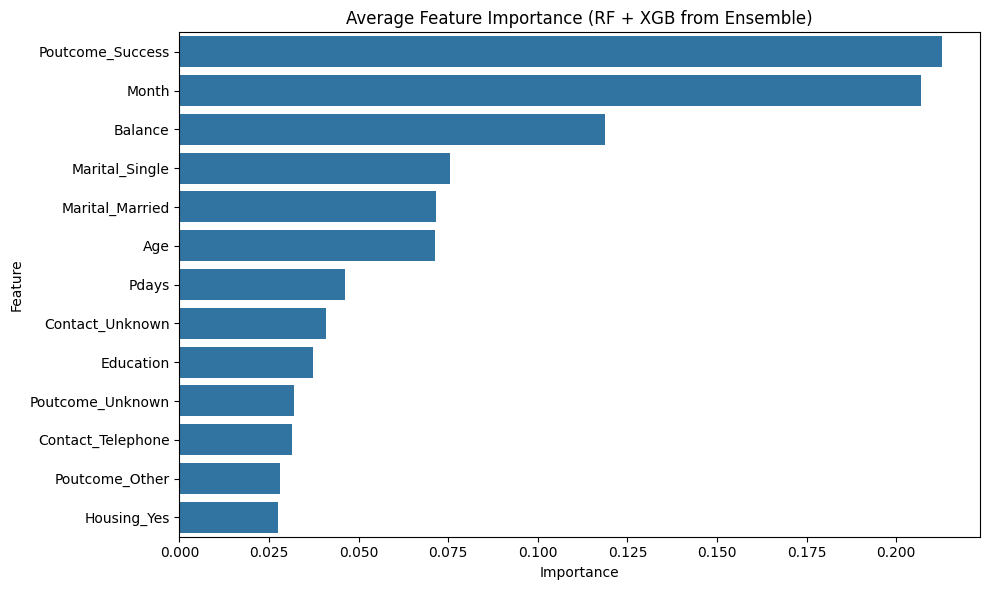

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the fitted models from ensemble
fitted_rf = best_ensemble.named_estimators_['rf']
fitted_xgb = best_ensemble.named_estimators_['xgb']

# Now you can get feature importances
rf_importances = fitted_rf.feature_importances_
xgb_importances = fitted_xgb.feature_importances_

# Average them as before
avg_importance = (rf_importances + xgb_importances) / 2
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Average Feature Importance (RF + XGB from Ensemble)")
plt.tight_layout()
plt.show()


# feature Engg

In [13]:
# feature

#model_data['Pdays_Cat'] = model_data['Pdays'].apply(lambda x: 'Not_Contacted' if x == -1 else 'Contacted')
#model_data.drop('Pdays', axis=1, inplace=True)  # optional: drop old column
#model_data = pd.get_dummies(model_data, columns=['Pdays_Cat'], drop_first=True)


In [14]:
model_data

,Age,Balance,Pdays,Education,Month,Y,Poutcome_Other,Poutcome_Success,Poutcome_Unknown,Housing_Yes,Marital_Married,Marital_Single,Contact_Telephone,Contact_Unknown
0,30,1787,-1,1,0.017695,0,False,False,True,False,True,False,False,False
1,33,4789,339,2,0.309224,0,False,False,False,True,True,False,False,False
2,35,1350,330,3,0.064809,0,False,False,False,True,False,True,False,False
3,30,1476,-1,3,0.117452,0,False,False,True,True,True,False,False,True
4,59,0,-1,2,0.309224,0,False,False,True,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,-333,-1,2,0.156160,0,False,False,True,True,True,False,False,False
4517,57,-3313,-1,3,0.309224,0,False,False,True,True,True,False,False,True
4518,57,295,-1,2,0.140013,0,False,False,True,False,True,False,False,False
4519,28,1137,211,2,0.049104,0,True,False,False,False,True,False,False,False


In [15]:
def run_model(dataframe, description=''):
    # Train-test split
    X = dataframe.drop('Y', axis=1)
    y = dataframe['Y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

    # Train ensemble model
    best_ensemble.fit(X_train_bal, y_train_bal)

    # Predict and threshold
    y_proba = best_ensemble.predict_proba(X_test)[:, 1]
    y_pred_thresh = (y_proba >= 0.6).astype(int)

    # Evaluation
    f1 = f1_score(y_test, y_pred_thresh)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n🔁 Model Evaluation ({description}):")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred_thresh))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))


In [16]:
run_model(model_data.copy(), description='Baseline')

# After pdays transformation
model_data_pdays = model_data.copy()
model_data_pdays['Pdays_Cat'] = model_data_pdays['Pdays'].apply(lambda x: 'Not_Contacted' if x == -1 else 'Contacted')
model_data_pdays.drop('Pdays', axis=1, inplace=True)
model_data_pdays = pd.get_dummies(model_data_pdays, columns=['Pdays_Cat'], drop_first=True)

run_model(model_data_pdays, description='With Pdays_Categorical')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (Baseline):
F1 Score: 0.3509
ROC AUC: 0.6923
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       801
           1       0.45      0.29      0.35       104

    accuracy                           0.88       905
   macro avg       0.68      0.62      0.64       905
weighted avg       0.86      0.88      0.87       905

Confusion Matrix:
 [[764  37]
 [ 74  30]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (With Pdays_Categorical):
F1 Score: 0.3145
ROC AUC: 0.7140
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       801
           1       0.45      0.24      0.31       104

    accuracy                           0.88       905
   macro avg       0.68      0.60      0.62       905
weighted avg       0.86      0.88      0.86       905

Confusion Matrix:
 [[771  30]
 [ 79  25]]


# Binned Balance

In [17]:
# === Feature Engineering: Binned Balance ===
model_data_balance_binned = model_data.copy()

# Create bins and labels
bins = [-np.inf, 0, 3000, np.inf]
labels = ['Low', 'Medium', 'High']
model_data_balance_binned['Balance_Binned'] = pd.cut(model_data_balance_binned['Balance'], bins=bins, labels=labels)

# Drop original Balance and one-hot encode the new categorical feature
model_data_balance_binned.drop('Balance', axis=1, inplace=True)
model_data_balance_binned = pd.get_dummies(model_data_balance_binned, columns=['Balance_Binned'], drop_first=True)

# Run model
run_model(model_data_balance_binned, description='With Balance Binned')


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (With Balance Binned):
F1 Score: 0.3030
ROC AUC: 0.6963
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       801
           1       0.32      0.29      0.30       104

    accuracy                           0.85       905
   macro avg       0.61      0.60      0.61       905
weighted avg       0.84      0.85      0.84       905

Confusion Matrix:
 [[737  64]
 [ 74  30]]


Age*Balance

In [18]:
# === Feature Engineering: Age * Balance ===
model_data_interact1 = model_data.copy()
model_data_interact1['Age_Balance'] = model_data_interact1['Age'] * model_data_interact1['Balance']

run_model(model_data_interact1, description='With Age * Balance Interaction')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (With Age * Balance Interaction):
F1 Score: 0.2963
ROC AUC: 0.7077
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       801
           1       0.41      0.23      0.30       104

    accuracy                           0.87       905
   macro avg       0.66      0.59      0.61       905
weighted avg       0.85      0.87      0.86       905

Confusion Matrix:
 [[767  34]
 [ 80  24]]


Age*Education

In [19]:
# === Feature Engineering: Age * Education ===
model_data_interact2 = model_data.copy()
model_data_interact2['Age_Education'] = model_data_interact2['Age'] * model_data_interact2['Education']

run_model(model_data_interact2, description='With Age * Education Interaction')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (With Age * Education Interaction):
F1 Score: 0.3394
ROC AUC: 0.6881
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       801
           1       0.46      0.27      0.34       104

    accuracy                           0.88       905
   macro avg       0.68      0.61      0.64       905
weighted avg       0.86      0.88      0.87       905

Confusion Matrix:
 [[768  33]
 [ 76  28]]


Months --> Quaters

In [20]:
# === Feature Engineering: Group Month into Quarters ===
model_data_quarters = model_data.copy()

# Define mapping of months to quarters
month_to_quarter = {
    'mar': 'Q1', 'apr': 'Q2', 'may': 'Q2', 'jun': 'Q2',
    'jul': 'Q3', 'aug': 'Q3',
    'sep': 'Q3', 'oct': 'Q4', 'nov': 'Q4', 'dec': 'Q4',
    'jan': 'Q1', 'feb': 'Q1'
}

# Inverse frequency-encoded column back to month labels if needed
# Skip this if you already preserved the original month labels
original_month = dataset['Month']  # assumes this is still available
model_data_quarters['Month_Quarter'] = original_month.map(month_to_quarter)

# Drop old frequency-encoded Month column
model_data_quarters.drop('Month', axis=1, inplace=True)

# One-hot encode quarter
model_data_quarters = pd.get_dummies(model_data_quarters, columns=['Month_Quarter'], drop_first=True)

run_model(model_data_quarters, description='With Month grouped into Quarters')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (With Month grouped into Quarters):
F1 Score: 0.2544
ROC AUC: 0.6836
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       801
           1       0.23      0.28      0.25       104

    accuracy                           0.81       905
   macro avg       0.57      0.58      0.57       905
weighted avg       0.83      0.81      0.82       905

Confusion Matrix:
 [[706  95]
 [ 75  29]]


Recency Flag

In [21]:
# === Feature Engineering: Recency Flag from Pdays ===
model_data_recency = model_data.copy()

# Create a binary feature: 1 if contacted within last 7 days, else 0
model_data_recency['Recently_Contacted'] = model_data_recency['Pdays'].apply(lambda x: 1 if x != -1 and x <= 7 else 0)

run_model(model_data_recency, description='With Recency Flag from Pdays')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:45:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (With Recency Flag from Pdays):
F1 Score: 0.3294
ROC AUC: 0.6940
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       801
           1       0.42      0.27      0.33       104

    accuracy                           0.87       905
   macro avg       0.67      0.61      0.63       905
weighted avg       0.85      0.87      0.86       905

Confusion Matrix:
 [[763  38]
 [ 76  28]]


Target Encoding: Job feature

In [22]:
# === Feature Engineering: Target Encoding for Job ===
model_data_job_te = model_data.copy()

# Copy the original dataset to get job column and target
job_target = dataset[['Job', 'Y']].copy()
job_target['Y'] = job_target['Y'].map({'Yes': 1, 'No': 0})

# Calculate mean success rate per job
job_encoding = job_target.groupby('Job')['Y'].mean()

# Map target encoding to the main model_data
model_data_job_te['Job_TE'] = dataset['Job'].map(job_encoding)

run_model(model_data_job_te, description='With Job Target Encoded')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:45:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (With Job Target Encoded):
F1 Score: 0.3200
ROC AUC: 0.7007
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       801
           1       0.52      0.23      0.32       104

    accuracy                           0.89       905
   macro avg       0.71      0.60      0.63       905
weighted avg       0.86      0.89      0.87       905

Confusion Matrix:
 [[779  22]
 [ 80  24]]


Age*Edu and Job

In [24]:
# Copy the model_data for transformation
model_data_combined = model_data.copy()

# 1. Correct target encoding for 'job'
job_target_encoding = dataset.groupby('Job')['Y'].apply(lambda x: (x == 'Yes').mean())
model_data_combined['Job_TE'] = dataset['Job'].map(job_target_encoding)

# 2. Create interaction feature between Age and Education
model_data_combined['Age_Education'] = model_data_combined['Age'] * model_data_combined['Education']

# 3. Run the model with both new features
run_model(model_data_combined, description='With Job Target Encoded + Age*Education Interaction')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:12:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔁 Model Evaluation (With Job Target Encoded + Age*Education Interaction):
F1 Score: 0.3129
ROC AUC: 0.6916
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       801
           1       0.53      0.22      0.31       104

    accuracy                           0.89       905
   macro avg       0.72      0.60      0.63       905
weighted avg       0.86      0.89      0.87       905

Confusion Matrix:
 [[781  20]
 [ 81  23]]
